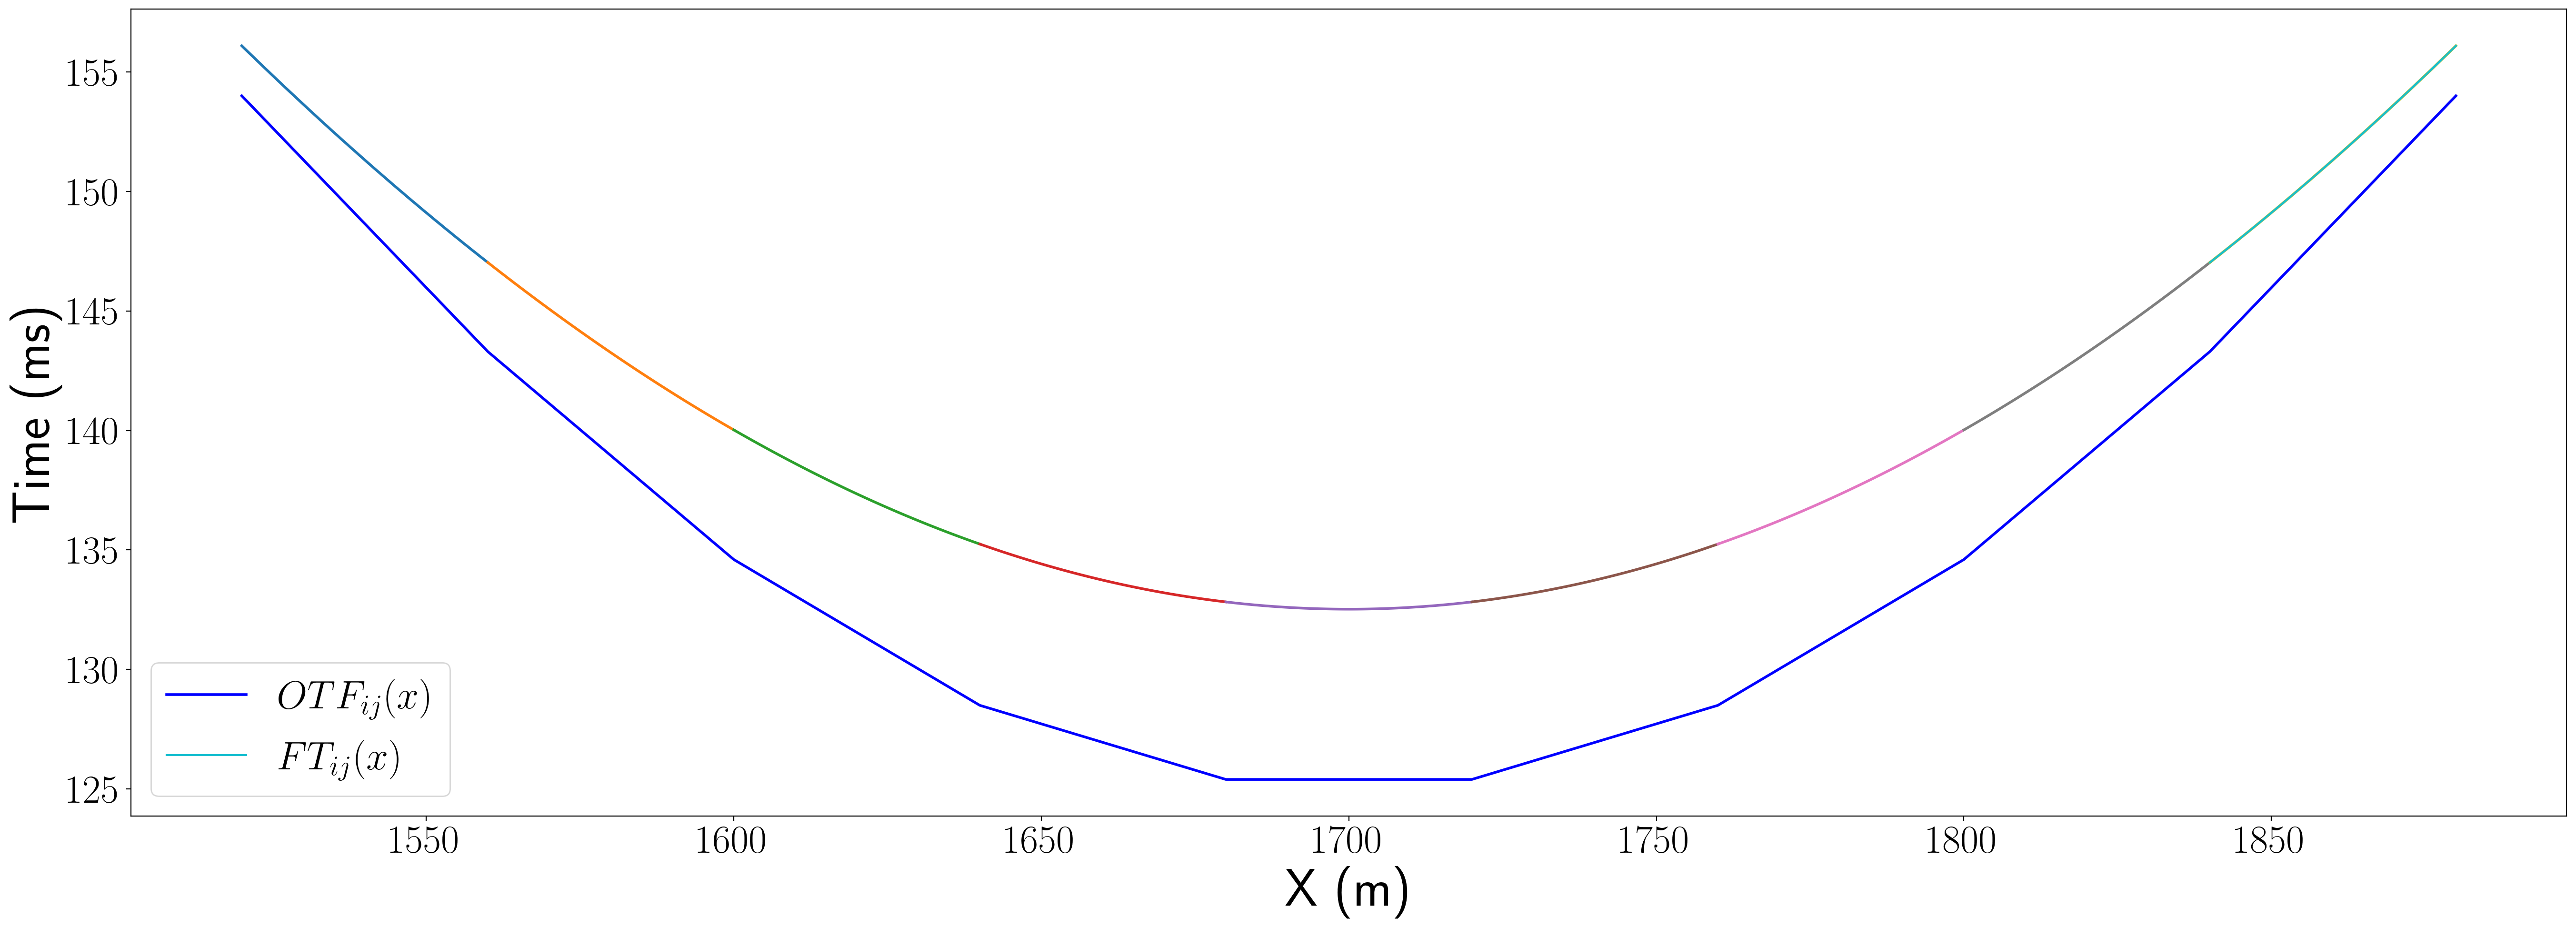

In [81]:
import pandas as pd
import numpy as np
import sympy as sp
import sympy
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

df = pd.read_csv('path/to/ShotReceData.csv')
# 通过条件筛选出符合要求的行
df_50010001_1001 = df[(df['ShotNum'] == 50010001) & (df['ReceNum'].between(10010001, 10010100))]
# df_50010001_1002 = df[(df['ShotNum'] == 50010001) & (df['ReceNum'].between(10020001, 10020100))]

#定义参数
#定义lambda
a=10**(-6.253)
#定义sigma
sigma = 2
#定义h
h = 40
#定义size
size = 100
#定义右端f_k
f = sp.Matrix(df_50010001_1001['First Time'].to_numpy())

#创建等号左端三对角
def create_tridiagonal_matrix1(size):
    matrix = sp.zeros(size, size)

    for i in range(size):
        if i == 0:
            matrix[i, i] = 1
        elif i == size - 1:
            matrix[i, i] = 1
        else:
            matrix[i, i] = 2
            matrix[i, i-1] = 0.5
            matrix[i, i+1] = 0.5

    return matrix

tri_mat1 = create_tridiagonal_matrix1(size)

#创建等号右端三对角
def create_tridiagonal_matrix2(size):
    matrix = sp.zeros(size, size)

    for i in range(size):
        if i in range(1 ,size-1 ):
            matrix[i, i] = -2
            matrix[i, i-1] = 1
            matrix[i, i+1] = 1

    return matrix

tri_mat2 = create_tridiagonal_matrix2(size)

#定义等号右端五对角
def create_fivediagonal_matrix(size):
    matrix = sympy.zeros(size, size)

    for i in range(size):
        if i == 1:
            matrix[i, i-1] = 3
            matrix[i, i] = -6
            matrix[i, i+1] = 4
            matrix[i, i+2] = -1
        elif i == size-2:
            matrix[i, i-2] = -1
            matrix[i, i-1] = 4
            matrix[i, i] = -6
            matrix[i, i+1] = 3
        elif i in range(2 ,size-2 ) :
            matrix[i, i-2] = -1
            matrix[i, i-1] = 4
            matrix[i, i] = -6
            matrix[i, i+1] = 4
            matrix[i, i+2] = -1

    return matrix

five_mat = create_fivediagonal_matrix(size)

# n = size-1 # n=99
# A = tri_mat1 - (3 * sigma ** 2)/(a * h ** 3) * five_mat
# b = (3 / h ** 2) * tri_mat2 * f
# M = A.solve(b)

# Y = sympy.zeros(size, 1)
# Y[0] = (sigma**2 / a*h) * (M[0] - M[1]) + f[0]
# Y[n] = (sigma**2 / a*h) * (M[n] - M[n-1]) + f[n]
# for k in range(1, n):
#     Y[k] = (sigma**2 / (a * h)) * (-M[k-1] + 2*M[k] - M[k+1]) + f[k]
    
# e = Y - f
# s = (e.T * e)[0]/ sigma**2
"""----------------------------------------------------------------------"""
#线性方程组矩阵
A = tri_mat1 - (3 * sigma ** 2)/(a * h ** 3) * five_mat
b = (3 / h ** 2) * tri_mat2 * f
M = A.solve(b)

#样条函数拟合值
n = size-1 # n=99
Y = sympy.zeros(size, 1)
Y[0] = (sigma**2 / (a*h)) * (M[0] - M[1]) + f[0]
Y[n] = (sigma**2 / (a*h)) * (M[n] - M[n-1]) + f[n]
for k in range(1, n):
    Y[k] = (sigma**2 / (a * h)) * (-M[k-1] + 2*M[k] - M[k+1]) + f[k]

ee = Y - f
ss=(ee.T * ee)[0]/ sigma**2

#分段样条函数
def S_k(x, k):
    return ( M[k-1]*(h*k - x)**3 ) / (6*h) +  ( M[k]*(x - h*(k-1))**3 ) / (6*h) + (Y[k-1] -  M[k-1]*h**2 / 6) * ((h*k - x) / h) + (Y[k] -  M[k]*h**2 / 6) * ((x-h*(k-1)) / h)

#绘制样条函数图及观测折线图
fig, ax = plt.subplots(figsize=(33, 11)) 

for k in range(39, 48):
    x_k = np.linspace(h*(k-1),h*k , 100)
    plt.plot(x_k, S_k(x_k, k), linewidth=2)

df_50010001_1001[(df_50010001_1001['Recex'] >= 1500) & (df_50010001_1001['Recex'] <= 1900)].plot(x='Recex', y='First Time', kind='line', linewidth=2, ax=ax, label='$OTF_{ij}(x)$' , color='b')

plt.rcParams.update({'text.usetex': True})
plt.plot(x_k, S_k(x_k, k), label='$FT_{ij}(x)$')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel('X (m)', fontsize=40)
plt.ylabel('Time (ms)', fontsize=40)
# plt.title('Graphs of $OFT_{ij}(x)$ and $TF_{ij}(x),i=50010001,j=1001$ with $x \in [1500,1900]$', fontsize=40)
plt.legend(loc='lower left', fontsize=30)
plt.show()

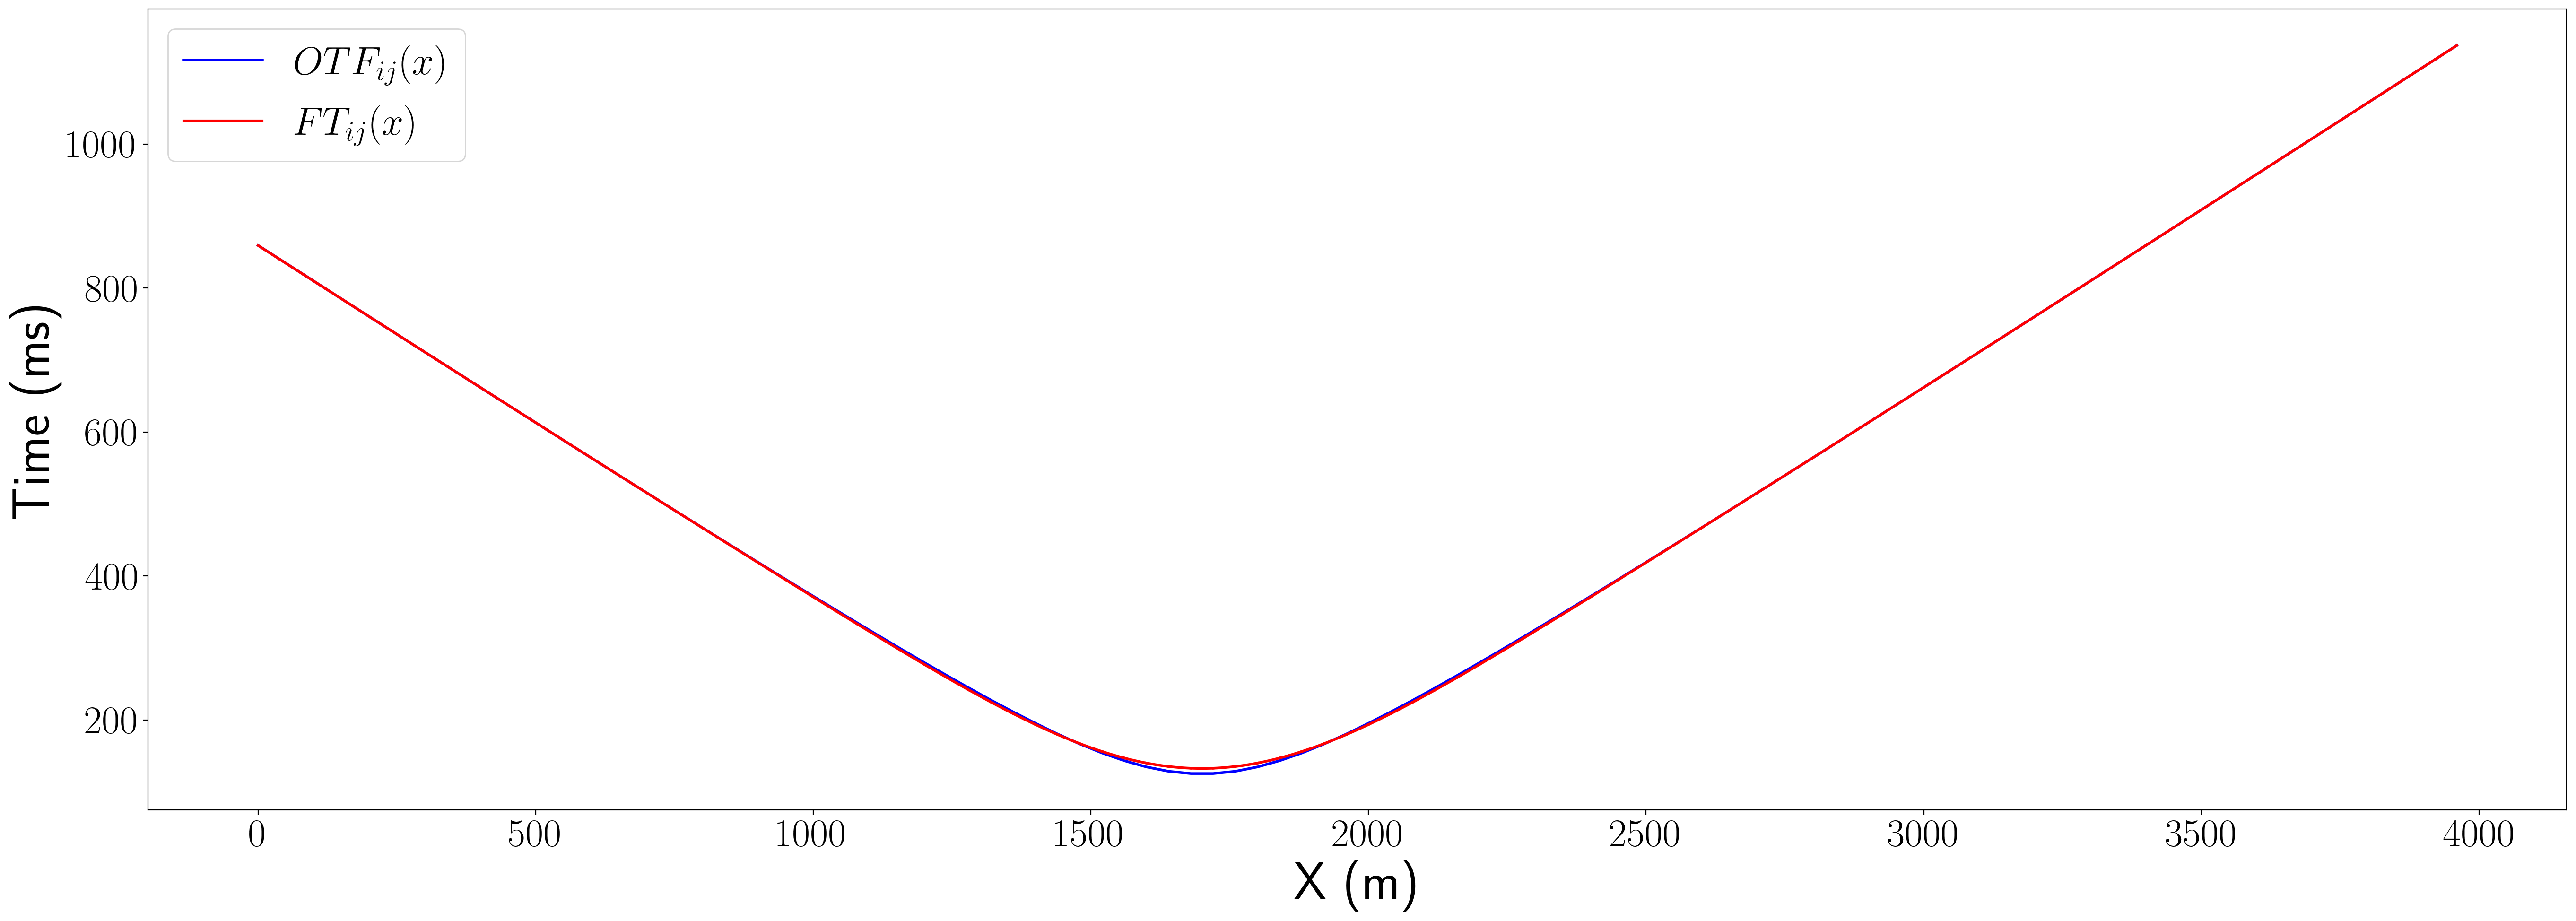

In [82]:
#绘制样条函数图及观测折线图
fig, ax = plt.subplots(figsize=(33, 11)) 

x = np.linspace(0, 3960 , 1000)

df_50010001_1001.plot(x='Recex', y='First Time', kind='line', linewidth=2, ax=ax, label='$OTF_{ij}(x)$' , color='b')

for k in range(1, size):
    x_k = np.linspace(h*(k-1),h*k , 100)
    plt.plot(x_k, S_k(x_k, k),linewidth=2, color='r')

plt.plot(x_k, S_k(x_k, k), label='$FT_{ij}(x)$', color='r')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel('X (m)', fontsize=40)
plt.ylabel('Time (ms)', fontsize=40)
# plt.title('Graphs of $OFT_{ij}(x)$ and $TF_{ij}(x),i=50010001,j=1001$ ', fontsize=40)
plt.legend(loc='upper left', fontsize=30)
plt.show()

In [92]:
e = Y - f
# e = pd.DataFrame(e)
pd.DataFrame(np.array(e)).to_csv('path/to/e.csv', index=False)
pd.DataFrame(np.array(Y)).to_csv('path/to/Y.csv', index=False)

In [ ]:
(e.T * e)[0]/ sigma**2

101.320972277180

In [ ]:
def create_matrix_for_shotnum(shot_num):
    group_df = df[df['ShotNum'] == shot_num]
    matrix_data = []
    for i in range(1, 21):
        sub_group_df = group_df[(group_df['ReceNum'].between((1000+i)*10000+1, (1000+i)*10000+100))] 
        matrix_data.append(sub_group_df['First Time'].tolist())

    matrix_df = pd.DataFrame(matrix_data).transpose()
    return matrix_df

for shot_num in df['ShotNum'].unique():
    matrix_for_shotnum = create_matrix_for_shotnum(shot_num)
    globals()['F%s' % shot_num] = matrix_for_shotnum

In [ ]:
c_values = []
c_values.append(Y)

In [ ]:
c_values.append(2*Y)

In [ ]:
c_values

[Matrix([
 [859.013824493692],
 [839.272718097789],
 [819.532571280179],
 [799.795202257885],
 [780.063027621977],
 [760.338648023483],
 [740.624833946795],
 [720.924143726641],
 [701.238894248685],
 [681.571163666585],
 [661.922805428837],
 [642.295752875941],
 [ 622.69185276577],
 [ 603.11295532661],
 [ 583.56094635122],
 [564.037555825993],
 [544.544075455037],
 [  525.0814168177],
 [505.650200680079],
 [486.251167032864],
 [466.885452921822],
 [447.554731044961],
 [428.261794451423],
 [409.011571524888],
 [389.812098006424],
 [370.675847347664],
 [351.621643460288],
 [332.677339407205],
 [313.882345217754],
 [295.290496807606],
 [276.972760656202],
 [259.019884863251],
 [241.545103140502],
 [224.686225755488],
 [ 208.60625143626],
 [193.492161471282],
 [179.551930575341],
 [167.008981749745],
 [156.093128584355],
 [147.029149522368],
 [140.023042554425],
 [135.247397583166],
 [132.826897125024],
 [132.826892522878],
 [135.247383862826],
 [140.023020015191],
 [147.029118798886],
 [1